In [ ]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, file_path, sequence_length, future_steps, mean, std):
    """
    Evaluates the model on a test dataset and plots the predictions vs actual values.
    """
    model.eval()  # Set the model to evaluation mode
    dataloader = create_dataloader(file_path, batch_size=1, sequence_length=sequence_length, future_steps=future_steps)

    predictions = []
    actuals = []
    time_steps = []

    with torch.no_grad():
        for i, (X, Y) in enumerate(dataloader):
            X = (X - mean) / std  # Normalize input
            X = X.to(device)

            output = model(X, future_steps=future_steps)
            output = output * std + mean  # Denormalize predictions
            Y = Y * std + mean  # Denormalize actuals

            predictions.append(output.cpu().numpy())
            actuals.append(Y.cpu().numpy())
            time_steps.append(np.arange(i, i + future_steps))

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    time_steps = np.concatenate(time_steps, axis=0)

    # Plot the results
    plt.figure(figsize=(15, 10))
    for i in range(predictions.shape[-1]):
        plt.subplot(predictions.shape[-1], 1, i + 1)
        plt.plot(time_steps, predictions[:, :, i].flatten(), label=f'Predicted Feature {i+1}', linestyle='--')
        plt.plot(time_steps, actuals[:, :, i].flatten(), label=f'Actual Feature {i+1}')
        plt.xlabel('Time Steps')
        plt.ylabel(f'Feature {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Hyperparameters and paths
file_path = "/path/to/test_dataset.csv"
mean = torch.tensor([mean_x, mean_y, mean_z])  # Mean values for each feature
std = torch.tensor([std_x, std_y, std_z])      # Std dev for each feature

# Load the model and evaluate
model = RNN(input_size=3, hidden_size=80, num_layers=2, num_classes=3)
model = load_model(model, 'rnn_model_future_steps.pth')

evaluate_and_plot(model, file_path, sequence_length=60, future_steps=20, mean=mean, std=std)


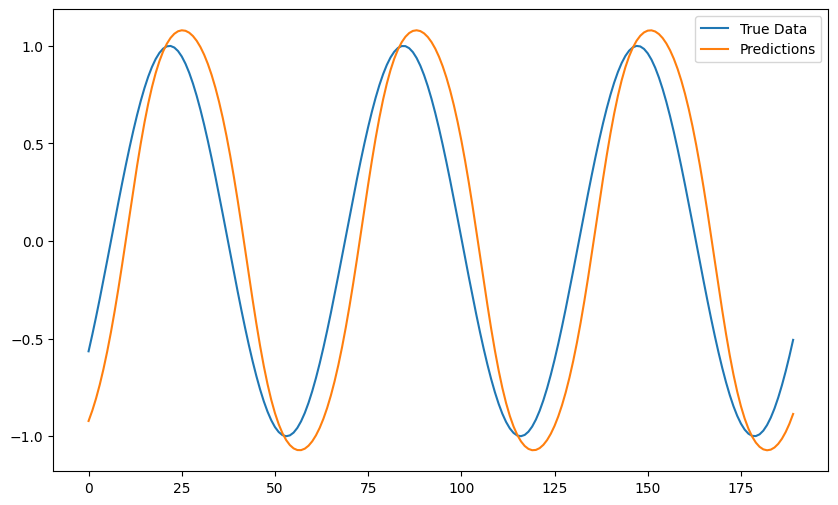

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=False):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          nonlinearity='tanh',
                          batch_first=batch_first)
        self.fc = nn.Linear(hidden_size, 1)  # Um das Ausgabeformat zu erzeugen

    def forward(self, x):
        out, _ = self.rnn(x)  # Vorwärtsdurchlauf durch das RNN
        out = self.fc(out[:, -1, :])  # Nur den letzten Zeitschritt verwenden
        return out


def train(model: RNNModel, data):
    # Modell, Verlustfunktion und Optimierer
    model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training des Modells
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Vorwärtsdurchlauf
        outputs = model(X_train)
        
        # Verlust berechnen
        loss = criterion(outputs.squeeze(), y_train)
        
        # Backpropagation und Optimierung
        loss.backward()
        optimizer.step()
        
        #if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Test des Modells
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)

    # Plotten der Ergebnisse
    plt.figure(figsize=(10,6))
    plt.plot(y_test.numpy(), label="True Data")
    plt.plot(predictions.numpy(), label="Predictions")
    plt.legend()
    plt.show()